# Language Model - Sentence / Word Tokenization

We first implement self, multi-head and cross-attention using a simple sentence and word embedding (adapted from the blog post self-attention from scratch : https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html) 

## Input Embedding

In [13]:
sentence = "Life is short, eat dessert first"
vocabulary = {s:i for i,s in enumerate(sorted(sentence.replace(',','').split()))}
print(vocabulary)
import torch
sentence_int = torch.tensor([vocabulary[s] for s in sentence.replace(',','').split()])
print(sentence_int)

{'Life': 0, 'dessert': 1, 'eat': 2, 'first': 3, 'is': 4, 'short': 5}
tensor([0, 4, 5, 2, 1, 3])


Next we can take this sentence representation and convert the integers into a 16 dimensional embedding space using pytorch.

In [14]:
torch.manual_seed(123)
embed = torch.nn.Embedding(6,16)
embedded_sentence = embed(sentence_int).detach()
print(embedded_sentence)
print(embedded_sentence.shape)

tensor([[ 0.3374, -0.1778, -0.3035, -0.5880,  0.3486,  0.6603, -0.2196, -0.3792,
          0.7671, -1.1925,  0.6984, -1.4097,  0.1794,  1.8951,  0.4954,  0.2692],
        [ 0.5146,  0.9938, -0.2587, -1.0826, -0.0444,  1.6236, -2.3229,  1.0878,
          0.6716,  0.6933, -0.9487, -0.0765, -0.1526,  0.1167,  0.4403, -1.4465],
        [ 0.2553, -0.5496,  1.0042,  0.8272, -0.3948,  0.4892, -0.2168, -1.7472,
         -1.6025, -1.0764,  0.9031, -0.7218, -0.5951, -0.7112,  0.6230, -1.3729],
        [-1.3250,  0.1784, -2.1338,  1.0524, -0.3885, -0.9343, -0.4991, -1.0867,
          0.8805,  1.5542,  0.6266, -0.1755,  0.0983, -0.0935,  0.2662, -0.5850],
        [-0.0770, -1.0205, -0.1690,  0.9178,  1.5810,  1.3010,  1.2753, -0.2010,
          0.4965, -1.5723,  0.9666, -1.1481, -1.1589,  0.3255, -0.6315, -2.8400],
        [ 0.8768,  1.6221, -1.4779,  1.1331, -1.2203,  1.3139,  1.0533,  0.1388,
          2.2473, -0.8036, -0.2808,  0.7697, -0.6596, -0.7979,  0.1838,  0.2293]])
torch.Size([6, 16])


In [15]:
# Calculate weight vectors for query, key, values

torch.manual_seed(123)

d = embedded_sentence.shape[1] # 16 dims

d_q, d_k, d_v = 24, 24, 28 # query / key dims must be same bc dot product

W_query = torch.nn.Parameter(torch.rand(d_q,d))
W_key = torch.nn.Parameter(torch.rand(d_k,d))
W_value = torch.nn.Parameter(torch.rand(d_v,d))

## Single Head Attention
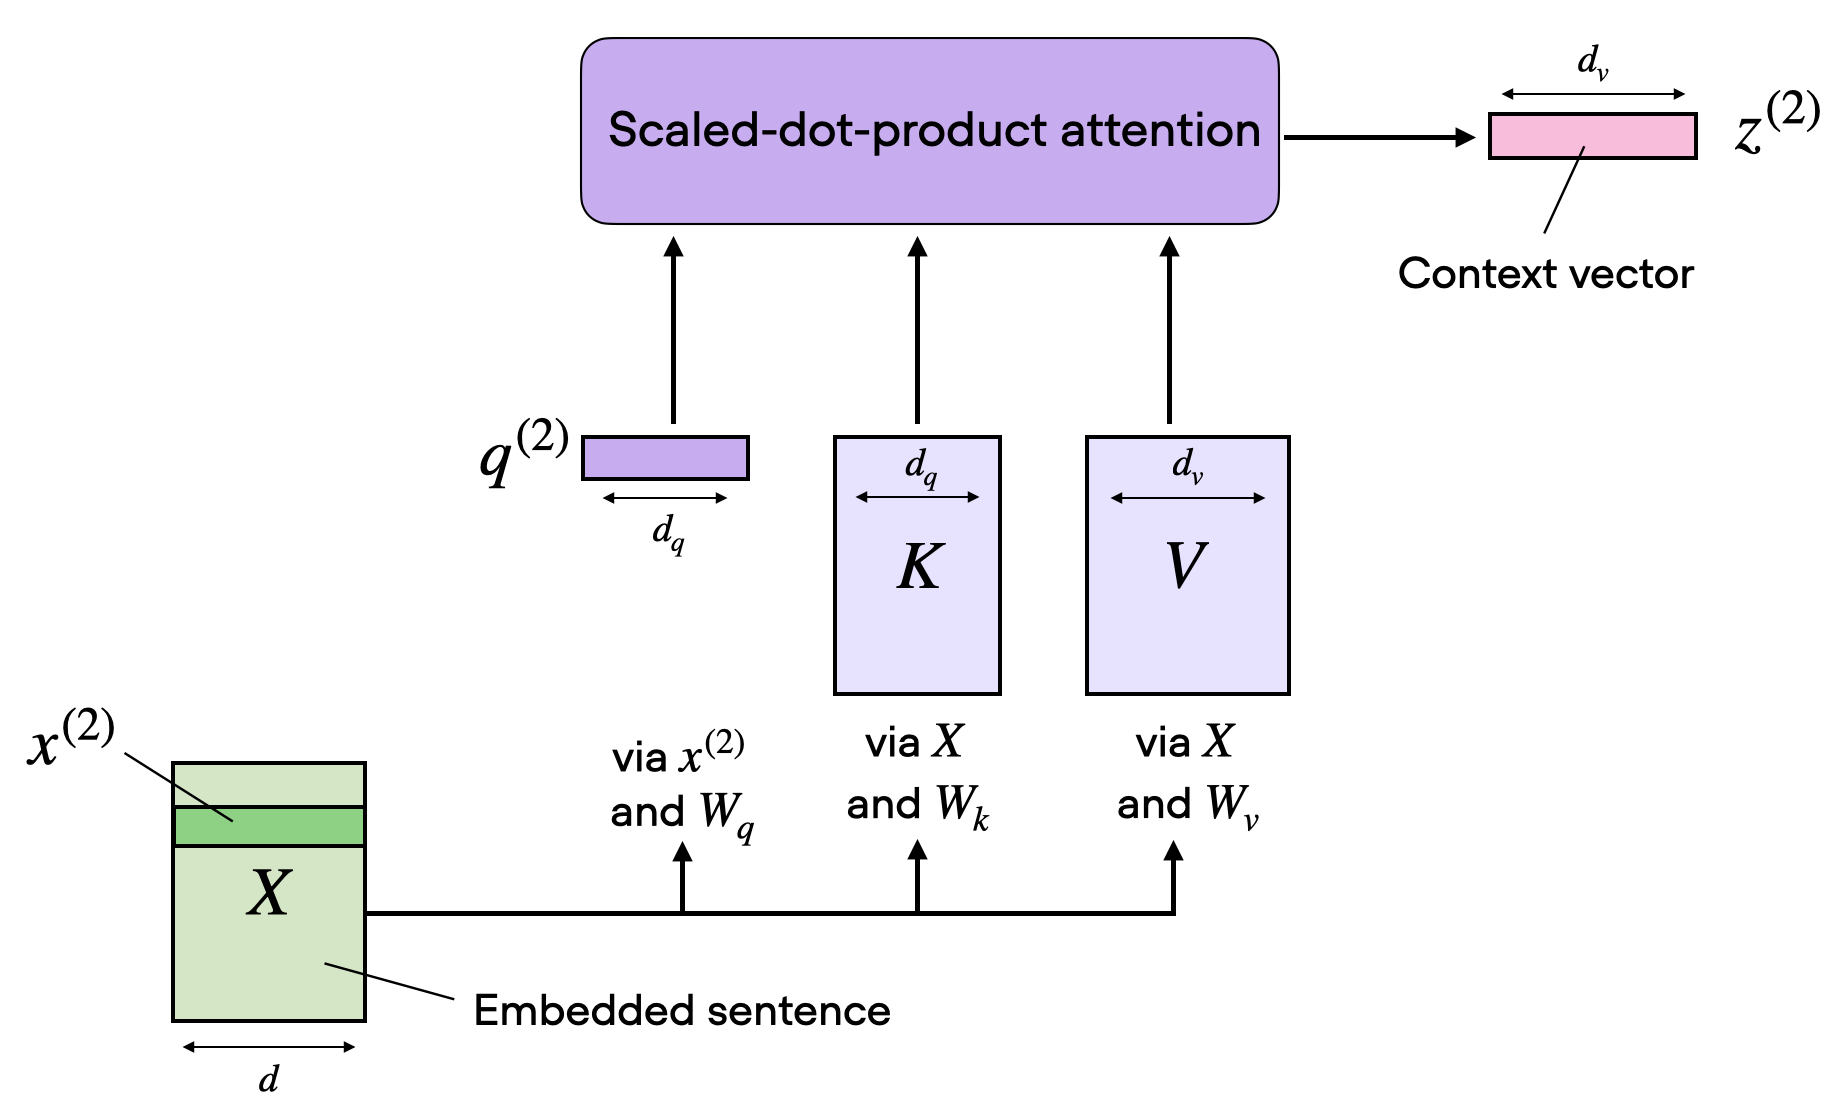

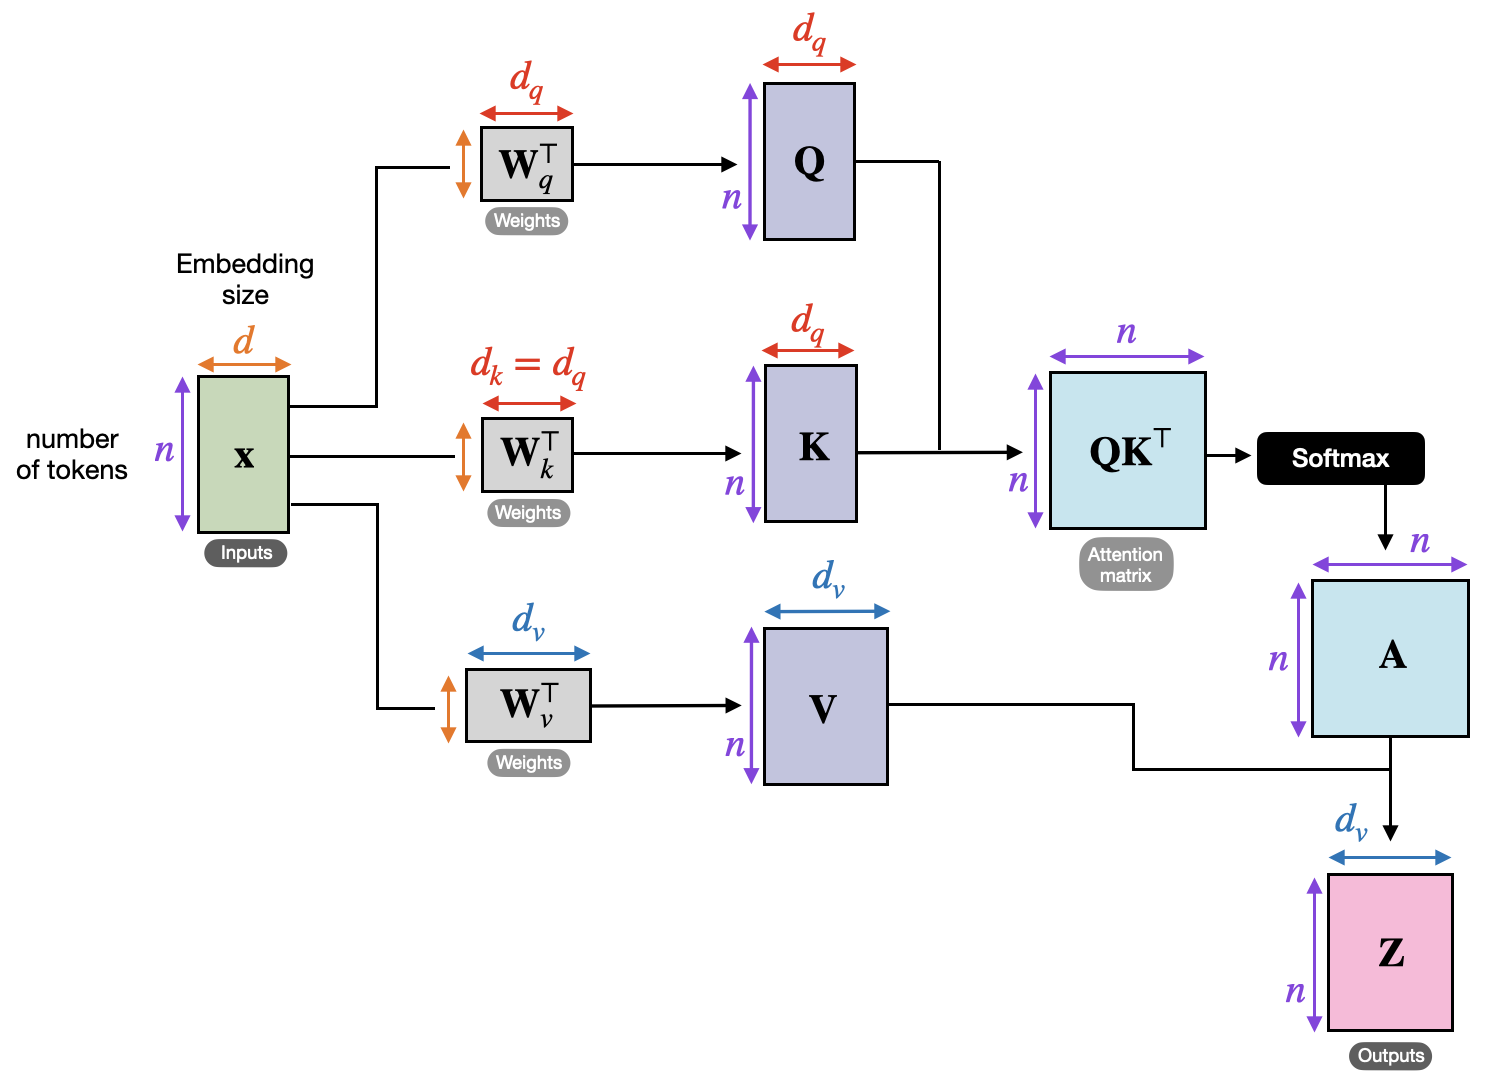

In [16]:
# calculated the unnormalized attention matrices Wx for x_2
x_2 = embedded_sentence[1]
query_2 = W_query.matmul(x_2)
key_2 = W_key.matmul(x_2)
value_2 = W_value.matmul(x_2)

print(query_2.shape)
print(key_2.shape)
print(value_2.shape)

# calculate remaining keys and values
keys = W_key.matmul(embedded_sentence.T).T
values = W_value.matmul(embedded_sentence.T).T
print(keys.shape)
print(values.shape)

# calculate \omega_i_j = q_i * k_j
omega_2_4 = query_2.dot(keys[4])
# \omega_2 for all input tokens
omega_2 = query_2.matmul(keys.T)
print(omega_2)

torch.Size([24])
torch.Size([24])
torch.Size([28])
torch.Size([6, 24])
torch.Size([6, 28])
tensor([ 8.5808, -7.6597,  3.2558,  1.0395, 11.1466, -0.4800],
       grad_fn=<SqueezeBackward3>)


In [17]:
# Compute the full attention score \alpha_2 = softmax(\omega_2/\sqrt{d_k}) for x_2
import torch.nn.functional as F

attention_weights_2 = F.softmax(omega_2 / d_k**0.5, dim=0)
print(attention_weights_2)

tensor([0.2912, 0.0106, 0.0982, 0.0625, 0.4917, 0.0458],
       grad_fn=<SoftmaxBackward0>)


In [18]:
# calculate the context vector z_2 = \sum_{j=1}^{T} attention_weights_2_j * v_j
context_vector_2 = attention_weights_2.matmul(values)
print(context_vector_2.shape)

torch.Size([28])


### Calculate full self-attention context vector

This is the final bit of code that gives us the full self-attention block. We can use this block for future developments

In [19]:
x = embedded_sentence
print("sentence embed:", x.shape)
queries = W_query.matmul(x.T)
print("Q matrix shape:", queries.shape)
omega = keys.matmul(queries)
print("QxK shape:", omega.shape)
attention_weights = F.softmax(omega/d_k**0.5, dim=0)
print("A shape:", attention_weights.shape)
context_vector = attention_weights.matmul(values)
print("Z shape:", context_vector.shape)

sentence embed: torch.Size([6, 16])
Q matrix shape: torch.Size([24, 6])
QxK shape: torch.Size([6, 6])
A shape: torch.Size([6, 6])
Z shape: torch.Size([6, 28])


## Multi-Head Attention
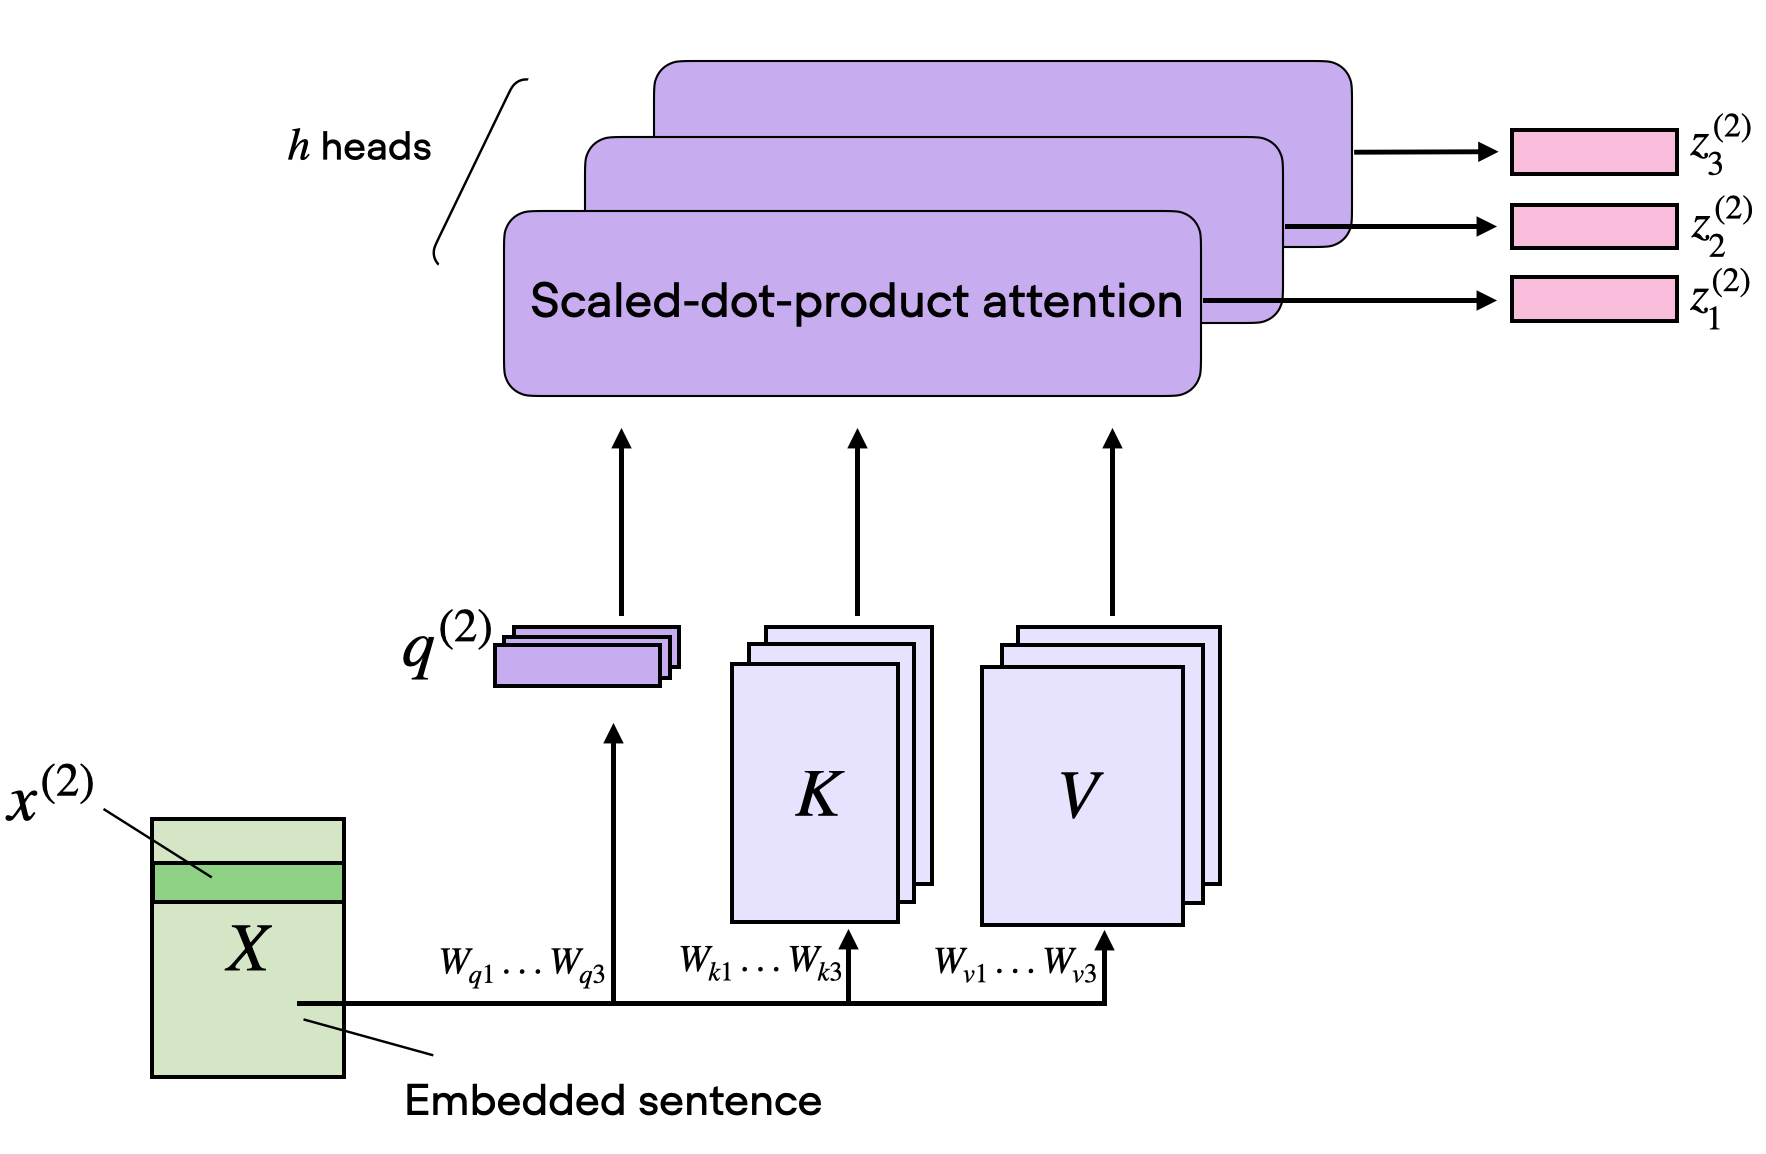

In [20]:
h = 3
multihead_W_query = torch.nn.Parameter(torch.rand(h,d_q,d))
multihead_W_key = torch.nn.Parameter(torch.rand(h,d_k,d))
multihead_W_value = torch.nn.Parameter(torch.rand(h,d_v,d))

In [21]:
multihead_query_2 = multihead_W_query.matmul(x_2)
print(multihead_query_2.shape)


torch.Size([3, 24])


In [22]:
stacked_inputs = embedded_sentence.T.repeat(3,1,1)
print(stacked_inputs.shape)
multihead_keys = torch.bmm(multihead_W_key, stacked_inputs)
multihead_values = torch.bmm(multihead_W_value, stacked_inputs)
print(multihead_keys.shape)
print(multihead_values.shape)

torch.Size([3, 16, 6])
torch.Size([3, 24, 6])
torch.Size([3, 28, 6])


In [23]:
# swap the 2nd and 3rd dims to make this easier to work with
print(multihead_query_2.shape)
print(multihead_keys.shape)
print(multihead_values.shape)

multihead_keys = multihead_keys.permute(0,2,1)
multihead_values = multihead_values.permute(0,2,1)

print(multihead_keys.shape)
print(multihead_values.shape)

torch.Size([3, 24])
torch.Size([3, 24, 6])
torch.Size([3, 28, 6])
torch.Size([3, 6, 24])
torch.Size([3, 6, 28])


In [24]:
# calculate the attention
print(multihead_keys[:,4,:].shape)
# calculate \omega_i_j = q_i * k_j
multihead_omega_2_4 = multihead_query_2.matmul(multihead_keys[:,4,:].T)
print(multihead_omega_2_4)

# \omega_2 for all input tokens
print(multihead_query_2.unsqueeze(-1).shape)
print(multihead_keys.shape)
multihead_omega_2 = torch.bmm(multihead_keys,multihead_query_2.unsqueeze(-1)) # 3x6x24 * 3x24x1
print(multihead_omega_2.shape)

# # Compute the full attention score \alpha_2 = softmax(\omega_2/\sqrt{d_k}) for x_2
import torch.nn.functional as F

multihead_attention_weights_2 = F.softmax(multihead_omega_2 / d_k**0.5, dim=0)
print(multihead_attention_weights_2.shape)

# calculate the context vector z_2 = \sum_{j=1}^{T} attention_weights_2_j * v_j
multihead_context_vector_2 = torch.bmm(multihead_attention_weights_2.permute(0,2,1),multihead_values)
print(multihead_context_vector_2.squeeze().shape)

torch.Size([3, 24])
tensor([[ 18.5821,  10.3134,  -4.6077],
        [-12.0696,  -5.8502,  -1.1828],
        [  7.1853,   7.2355,  -1.9436]], grad_fn=<MmBackward0>)
torch.Size([3, 24, 1])
torch.Size([3, 6, 24])
torch.Size([3, 6, 1])
torch.Size([3, 6, 1])
torch.Size([3, 28])


### Calculate the full multi-head attention context vector

In [27]:
x = embedded_sentence
print("sentence embed:", x.shape) # 6x16
multihead_queries = multihead_W_query.matmul(x.T) # 3x24x6
print("Q shape:", multihead_queries.shape)
multihead_omega = torch.bmm(multihead_keys,multihead_queries) # 3x6x24 mult 3x24x6
print("QxK shape:", multihead_omega.shape) #3x6x6
multihead_attention_weights = F.softmax(multihead_omega/d_k**0.5, dim=0)
print("A shape:", multihead_attention_weights.shape) # 3x6x6
multihead_context_vector = torch.bmm(multihead_attention_weights,multihead_values) # 3x6x6 mult 3x6x28
print("Z shape:", multihead_context_vector.shape) # 3x6x28

sentence embed: torch.Size([6, 16])
Q shape: torch.Size([3, 24, 6])
QxK shape: torch.Size([3, 6, 6])
A shape: torch.Size([3, 6, 6])
Z shape: torch.Size([3, 6, 28])


## Cross Attention

This includese multiple size inputs (note both `n` and `m` as different size of inputs - e.g. `m` could be from encoder sequences vs. `n` could be from the decoder sequences)

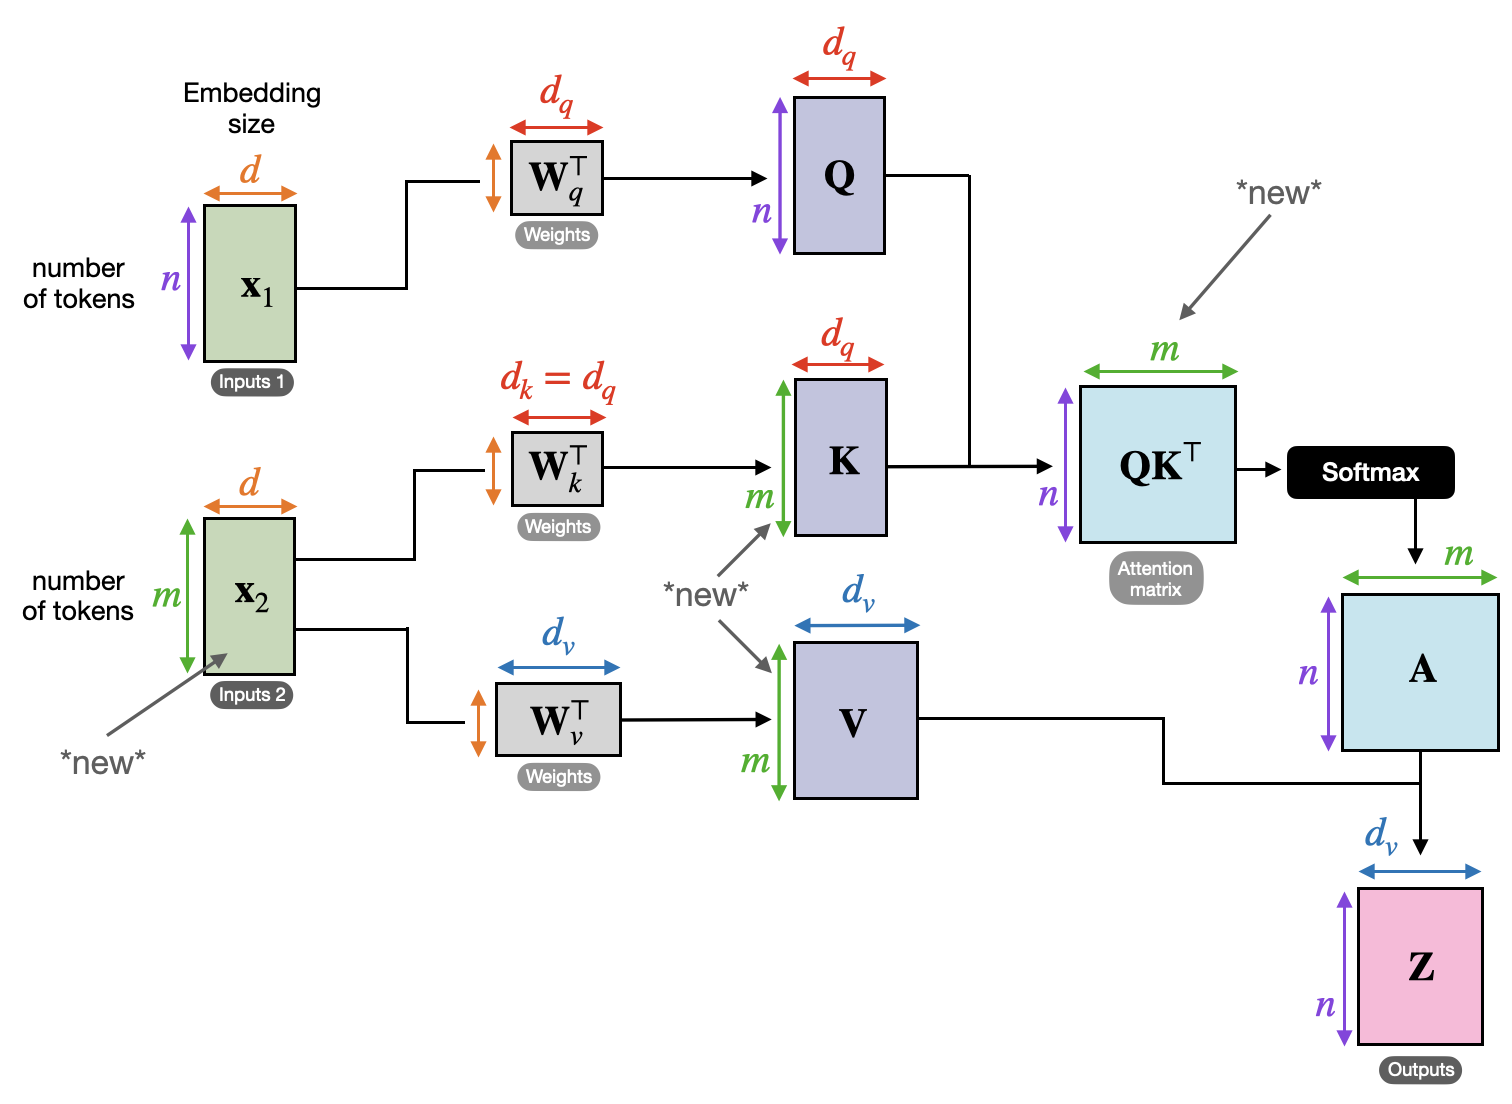



In [28]:
torch.manual_seed(123)

# still the same 6x16 embedding from original sentence: n=6 - no changes
print("embedded_sentence.shape:", embedded_sentence.shape)

# no change to embedding dimentions or weight matrices
print(d_q,d_k,d_v)
print(W_query.shape)
print(W_key.shape)
print(W_value.shape)
print(query_2.shape)

# let's take the keys and values from the second input - a sentence with 8 words (8x16)
# note: the embedding dims of the two inputs must be the same: m=8
embedded_sentence_2 = torch.rand(8,16)
ca_keys = W_key.matmul(embedded_sentence_2.T).T
ca_values = W_value.matmul(embedded_sentence_2.T).T

print("cross attention keys.shape:", ca_keys.shape)
print("cross attention values.shape:", ca_values.shape)

embedded_sentence.shape: torch.Size([6, 16])
24 24 28
torch.Size([24, 16])
torch.Size([24, 16])
torch.Size([28, 16])
torch.Size([24])
cross attention keys.shape: torch.Size([8, 24])
cross attention values.shape: torch.Size([8, 28])


In [29]:
ca_omega_2 = query_2.matmul(ca_keys.T)
print(ca_omega_2.shape)

# Compute the full attention score \alpha_2 = softmax(\omega_2/\sqrt{d_k}) for x_2
import torch.nn.functional as F

ca_attention_weights_2 = F.softmax(ca_omega_2 / d_k**0.5, dim=0)
print("cross attention weights dim:", ca_attention_weights_2.shape)



torch.Size([8])
cross attention weights dim: torch.Size([8])


In [30]:
# calculate the context vector z_2 = \sum_{j=1}^{T} attention_weights_2_j * v_j
context_vector_2 = ca_attention_weights_2.matmul(ca_values)
print(context_vector_2.shape)

torch.Size([28])


### Calculate the full cross-attention context vector

In [31]:
x_1 = embedded_sentence # 6x16
x_2 = embedded_sentence_2 # 8x16
print("sentence 1 embed:", x_1.shape)
print("sentence 2 embed:", x_2.shape)
# query will be the same as for single head attention because we take it from x_1
queries = W_query.matmul(x.T)
print("Q matrix shape:", queries.shape) # 24x6
ca_omega = queries.T.matmul(ca_keys.T) #  6x24 mult 24x8
print("QxK shape:", ca_omega.shape)
ca_attention_weights = F.softmax(ca_omega/d_k**0.5, dim=0) # 6x8
print("A shape:", ca_attention_weights.shape) # 6x8
ca_context_vector = ca_attention_weights.matmul(ca_values) # 6x8 mult 8x28
print("Z shape:", ca_context_vector.shape) #6x28

sentence 1 embed: torch.Size([6, 16])
sentence 2 embed: torch.Size([8, 16])
Q matrix shape: torch.Size([24, 6])
QxK shape: torch.Size([6, 8])
A shape: torch.Size([6, 8])
Z shape: torch.Size([6, 28])
